In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import importlib
import user_history_builder
importlib.reload(user_history_builder)
from user_history_builder import UserHistoryFeatureGenerator, BoostingFeaturesConfig

In [3]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score
from sklearn.calibration import calibration_curve

import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

/data/kyudin/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Обучение модели градиентного бустинга
    Обучим градиентный бустинг на классификацию пола пользователей Rutube
    
    - В качестве фичей будем считать статистики пользователей (аггрегации по численным признакам, value_counts по категориальным и др.)
    - Разбиение на 70/10/20, подбор гиперпараметров с использованием Optuna с оптимизацией F1 метрики
    - Сравнение качества с top и random предсказаниями

    В классе BoostingFeaturesConfig будем держать конфиг с описанием признаков пользователей/видео и списком функций аггрегации по каждому из них.
    UserHistoryFeatureGenerator на основе конфига аггрегирует данные по пользователям

In [4]:
path = r'/home/kyudin/jmlc/data/'
data = pd.read_csv(path + 'auth_users_gender_events.csv')
sex_labels = pd.read_csv(path + 'auth_sex_labels.csv')

In [5]:
sex_labels.head()

,viewer_id,sex
0,46290287,male
1,46290338,female
2,46290351,male
3,46290369,male
4,46290388,female


In [6]:
data.columns

Index(['event_date', 'viewer_id', 'video_id', 'total_watchtime', 'duration',
       'category_id', 'local_hour', 'ua_os', 'ua_client_name', 'day_of_week',
       'time_of_day', 'author', 'v_channel_type', 'v_year_views',
       'cumulative_male', 'cumulative_female', 'video_users_total',
       'cumulative_under_18', 'cumulative_18_24', 'cumulative_25_34',
       'cumulative_35_44', 'cumulative_45_54', 'video_users_total_age'],
      dtype='object')

In [7]:
data['cumulative_male_ratio'] = data['cumulative_male'] / data[['cumulative_male', 'cumulative_female']].sum(axis=1)
data['cumulative_female_ratio'] = data['cumulative_female'] / data[['cumulative_male', 'cumulative_female']].sum(axis=1)

data['cumulative_under_18_ratio'] = data['cumulative_under_18'] / data['video_users_total_age']
data['cumulative_18_24_ratio'] = data['cumulative_18_24'] / data['video_users_total_age']
data['cumulative_25_34_ratio'] = data['cumulative_25_34'] / data['video_users_total_age']
data['cumulative_35_44_ratio'] = data['cumulative_35_44'] / data['video_users_total_age']
data['cumulative_45_54_ratio'] = data['cumulative_45_54'] / data['video_users_total_age']

data['category_id'] = data['category_id'].astype(str)

In [8]:
def train_val_test_split(
    labels: pd.DataFrame,
    train_size: float,
    val_size: float
):
    """
    Args:
        labels (pd.DataFrame): Authorized users age/sex DataFrame
        train_size (float): train size
        val_size (float): validation size 

    Returns:
        Train/Val/Test DataFrames with labels
    """

    assert labels["viewer_id"].nunique() == len(labels), "..."

    unique_users = labels['viewer_id'].to_numpy().copy()
    np.random.shuffle(unique_users)

    n_users = len(unique_users)
    n_train = int(n_users * train_size)
    n_val = int(n_users * val_size)


    train_users = unique_users[:n_train]
    val_users = unique_users[n_train:n_train + n_val]
    test_users = unique_users[n_train + n_val:]

    train_labels = labels[labels["viewer_id"].isin(train_users)].copy()
    val_labels = labels[labels["viewer_id"].isin(val_users)].copy()
    test_labels = labels[labels["viewer_id"].isin(test_users)].copy()

    return train_labels, val_labels, test_labels

In [9]:
train_labels, val_labels, test_labels = train_val_test_split(
    sex_labels,
    train_size=0.7,
    val_size=0.1
)

In [10]:
train_ids = train_labels['viewer_id'].values
val_ids = val_labels['viewer_id'].values
test_ids = test_labels['viewer_id'].values


train_events = data[data['viewer_id'].isin(train_ids)].copy()
val_events = data[data['viewer_id'].isin(val_ids)].copy()
test_events = data[data['viewer_id'].isin(test_ids)].copy()

In [11]:
feature_conf = BoostingFeaturesConfig()
builder = UserHistoryFeatureGenerator(feature_conf)

In [12]:
X_train = builder.fit_transform(train_events)
X_val = builder.fit_transform(val_events)
X_test = builder.fit_transform(test_events)

In [13]:
sex_labels = sex_labels.set_index('viewer_id')

train_labels = sex_labels.loc[X_train.index]
val_labels = sex_labels.loc[X_val.index]
test_labels = sex_labels.loc[X_test.index]

<Axes: xlabel='sex', ylabel='count'>

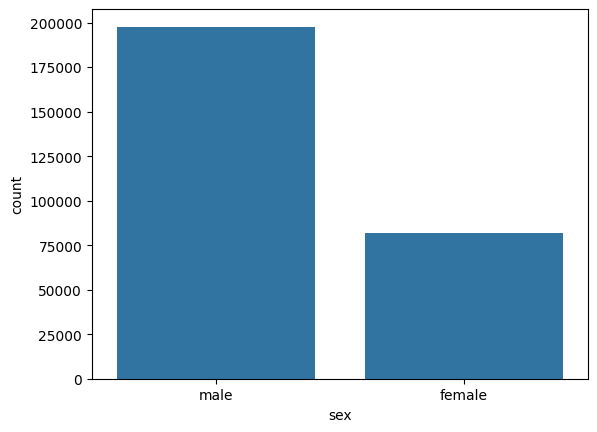

In [14]:
sns.countplot(
    x=train_labels['sex']
)

In [15]:
label2class = {1: "female", 0 : "male"}
class2label = {"female" : 1, "male" : 0}

y_train = train_labels['sex'].map(class2label)
y_val = val_labels['sex'].map(class2label)
y_test = test_labels['sex'].map(class2label)

In [81]:
print("Пользователей в трейне", y_train.shape[0])
print("Пользователей в валидации", y_val.shape[0])
print("Пользователей в тесте", y_test.shape[0])

Пользователей в трейне 279387
Пользователей в валидации 39954
Пользователей в тесте 79779


# Обучение модели

In [21]:
cols_to_drop = ['cumulative_male_ratio_median', 'cumulative_female_ratio_sum', 'cumulative_female_ratio_max', 'cumulative_male_ratio_std']
X_train = X_train.drop(cols_to_drop, axis=1)
X_val = X_val.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

In [23]:
def objective(trial):
    hpspace = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500, step=100),
        'colsample_bylevel' : trial.suggest_float('colsample_bylevel', 0.35, 0.9, step=0.11),
        'subsample': trial.suggest_float('subsample', 0.35, 0.9, step=0.11),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.5, 5, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50, log=True), 
    }

    clf = CatBoostClassifier(
        eval_metric='F1',
        early_stopping_rounds=60,
        **hpspace
    )
    clf.fit(X_train, y_train, verbose=False, eval_set=(X_val, y_val))
    preds = clf.predict(X_test)
    score = f1_score(y_test, preds)

    return score

In [24]:
study = optuna.create_study(
    direction='maximize',
    storage=None
)

study.optimize(objective, n_trials=15)

[I 2025-07-07 23:35:13,861] A new study created in memory with name: no-name-256901c6-2e41-44e0-ae76-0d9ce94ece9f
[I 2025-07-07 23:35:21,677] Trial 0 finished with value: 0.5157268058359098 and parameters: {'max_depth': 9, 'learning_rate': 0.16214656930788382, 'n_estimators': 300, 'colsample_bylevel': 0.9, 'subsample': 0.45999999999999996, 'l2_leaf_reg': 0.7605715312127469, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.5157268058359098.
[I 2025-07-07 23:35:41,016] Trial 1 finished with value: 0.5187621086978689 and parameters: {'max_depth': 11, 'learning_rate': 0.06620233939000941, 'n_estimators': 800, 'colsample_bylevel': 0.6799999999999999, 'subsample': 0.57, 'l2_leaf_reg': 0.532711377869209, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.5187621086978689.
[I 2025-07-07 23:35:42,560] Trial 2 finished with value: 0.5456546623227965 and parameters: {'max_depth': 5, 'learning_rate': 0.3575978476417086, 'n_estimators': 1200, 'colsample_bylevel': 0.79, 'subsample': 0.9, 'l

# Метрики качества

In [30]:
clf = CatBoostClassifier(
        eval_metric='F1',
        early_stopping_rounds=60,
        **study.best_params
)
clf.fit(X_train, y_train, verbose=False, eval_set=(X_val, y_val))

pred_proba = clf.predict_proba(X_test)
preds = clf.predict(X_test)
test_f1 = f1_score(y_test, preds)
test_roc_auc = roc_auc_score(y_test, pred_proba[:, 1])

const_preds = [1] * len(y_test)
const_f1 = f1_score(y_test, const_preds)


random_preds = np.random.choice([0, 1], size=len(y_test))
random_f1 = f1_score(y_test, random_preds)


metrics = pd.DataFrame(columns=["Method", "F1", "ROC-AUC"])
metrics.loc[len(metrics)] = ["CatBoost", test_f1, test_roc_auc]
metrics.loc[len(metrics)] = ["Const", const_f1, 0.5]
metrics.loc[len(metrics)] = ["Random", random_f1, 0.5]
metrics


,Method,F1,ROC-AUC
0,CatBoost,0.560216,0.754107
1,Const,0.453446,0.500000
2,Random,0.374698,0.500000
